# Multi-Agent Applications: Building Agent Teams with LangGraph

In this notebook, we'll explore **multi-agent systems** - applications where multiple specialized agents collaborate to solve complex tasks. We'll build on our LangGraph foundation from Session 4 and create agent teams for our Personal Wellness Assistant.

**Learning Objectives:**
- Understand when and why to use multi-agent systems
- Master the Supervisor pattern for orchestrating agent teams
- Implement Agent Handoffs for dynamic task routing
- Use Tavily Search for web research capabilities
- Apply context engineering principles to optimize agent performance
- Visualize and debug multi-agent systems with LangSmith

## Table of Contents:

- **Breakout Room #1:** Multi-Agent Fundamentals & Supervisor Pattern
  - Task 1: Dependencies & Environment Setup
  - Task 2: Understanding Multi-Agent Systems
  - Task 3: Building a Supervisor Agent Pattern
  - Task 4: Adding Tavily Search for Web Research
  - Question #1 & Question #2
  - Activity #1: Add a Custom Specialist Agent

- **Breakout Room #2:** Handoffs & Context Engineering
  - Task 5: Agent Handoffs Pattern
  - Task 6: Building a Wellness Agent Team
  - Task 7: Context Engineering & Optimization
  - Task 8: Visualizing and Debugging with LangSmith
  - Question #3 & Question #4
  - Activity #2: Implement Hierarchical Teams

---
# 🤝 Breakout Room #1
## Multi-Agent Fundamentals & Supervisor Pattern

## Task 1: Dependencies & Environment Setup

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-5.2 supervisor and GPT-4o-mini specialist agents)
   - Tavily (free tier at [tavily.com](https://www.tavily.com/))
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

**Models Used:**
- **GPT-5.2**: Supervisor/orchestrator agents (better reasoning for routing decisions)
- **GPT-4o-mini**: Specialist agents (cost-effective for domain-specific tasks)

**Documentation:**
- [Tavily Search API](https://docs.tavily.com/)

In [1]:
# Core imports
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [2]:
# Set API Keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [3]:
# Tavily API Key for web search
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

In [4]:
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Applications - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - Multi-Agent Applications - 79a7eece


In [5]:
# Initialize LLMs - GPT-5.2 for supervisors, GPT-4o-mini for specialists
from langchain_openai import ChatOpenAI

# Supervisor model - better reasoning for routing and orchestration
supervisor_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test both models
print("Testing models...")
supervisor_response = supervisor_llm.invoke("Say 'Supervisor ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Supervisor (GPT-5.2): {supervisor_response.content}")
print(f"Specialist (GPT-4o-mini): {specialist_response.content}")

Testing models...
Supervisor (GPT-5.2): Supervisor ready!
Specialist (GPT-4o-mini): Specialist ready!


## Task 2: Understanding Multi-Agent Systems

### When to Use Multi-Agent Systems

Before building multi-agent systems, ask yourself:

> **"Do I really need several specialized dynamic reasoning machines collaborating to solve this task more effectively than a single agent could?"**

Multi-agent systems are useful when:
1. **Tool/responsibility grouping**: Different tasks require different expertise
2. **Prompt separation**: Different agents need different instructions/few-shot examples
3. **Piecewise optimization**: Easier to improve individual components

### Key Multi-Agent Patterns

| Pattern | Description | Use Case |
|---------|-------------|----------|
| **Supervisor** | Central orchestrator routes to specialist agents | Task delegation, quality control |
| **Handoffs** | Agents transfer control to each other | Conversation flows, expertise routing |
| **Hierarchical** | Supervisors manage teams of agents | Large-scale systems, departments |
| **Network/Swarm** | Agents communicate freely | Collaborative problem-solving |

### Context Engineering Principles

From leading practitioners:

- **Dex Horthy (12-Factor Agents)**: "Own your context window and treat it like prime real estate"
- **swyx (Agent Engineering)**: "Agent reliability = great context construction"
- **Chroma (Context Rot)**: "Longer ≠ better when it comes to context"

**Documentation:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)

## Task 3: Building a Supervisor Agent Pattern

The **Supervisor Pattern** uses a central agent to:
1. Analyze incoming requests
2. Route to the appropriate specialist agent
3. Aggregate and refine responses

```
                    ┌─────────────────┐
                    │   Supervisor    │
                    │   (Orchestrator)│
                    └────────┬────────┘
                             │
           ┌─────────────────┼─────────────────┐
           │                 │                 │
           ▼                 ▼                 ▼
    ┌────────────┐    ┌────────────┐    ┌────────────┐
    │  Exercise  │    │  Nutrition │    │   Sleep    │
    │   Agent    │    │   Agent    │    │   Agent    │
    └────────────┘    └────────────┘    └────────────┘
```

**Documentation:**
- [LangGraph Supervisor Tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [6]:
# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

LangGraph and LangChain components imported!


In [7]:
# First, let's set up our RAG system for the wellness knowledge base
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

Loaded and split into 45 chunks


In [8]:
# Set up vector store
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="wellness_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="wellness_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} documents")

Vector store ready with 45 documents


In [11]:
# Create specialized tools for each agent domain

@tool
def search_exercise_info(query: str) -> str:
    """Search for exercise, fitness, and workout information from the wellness knowledge base.
    Use this for questions about physical activity, workout routines, and exercise techniques.
    """
    results = retriever.invoke(f"exercise fitness workout {query}")
    if not results:
        return "No exercise information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_nutrition_info(query: str) -> str:
    """Search for nutrition, diet, and healthy eating information from the wellness knowledge base.
    Use this for questions about food, meal planning, and dietary guidelines.
    """
    results = retriever.invoke(f"nutrition diet food meal {query}")
    if not results:
        return "No nutrition information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_sleep_info(query: str) -> str:
    """Search for sleep, rest, and recovery information from the wellness knowledge base.
    Use this for questions about sleep quality, insomnia, and sleep hygiene.
    """
    results = retriever.invoke(f"sleep rest recovery insomnia {query}")
    if not results:
        return "No sleep information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_stress_info(query: str) -> str:
    """Search for stress management and mental wellness information from the wellness knowledge base.
    Use this for questions about stress, anxiety, mindfulness, and mental health.
    """
    results = retriever.invoke(f"stress mental wellness mindfulness anxiety {query}")
    if not results:
        return "No stress management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

print("Specialist tools created!")

Specialist tools created!


In [12]:
# Create specialist agents using create_agent (LangChain 1.0 API)
# Each specialist uses GPT-4o-mini for cost efficiency

exercise_agent = create_agent(
    model=specialist_llm,
    tools=[search_exercise_info],
    system_prompt="You are an Exercise Specialist. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

nutrition_agent = create_agent(
    model=specialist_llm,
    tools=[search_nutrition_info],
    system_prompt="You are a Nutrition Specialist. Help users with diet advice, meal planning, and healthy eating. Always search the knowledge base before answering. Be concise and helpful."
)

sleep_agent = create_agent(
    model=specialist_llm,
    tools=[search_sleep_info],
    system_prompt="You are a Sleep Specialist. Help users with sleep quality, insomnia, and rest optimization. Always search the knowledge base before answering. Be concise and helpful."
)

stress_agent = create_agent(
    model=specialist_llm,
    tools=[search_stress_info],
    system_prompt="You are a Stress Management Specialist. Help users with stress relief, mindfulness, and mental wellness. Always search the knowledge base before answering. Be concise and helpful."
)

print("Specialist agents created (using GPT-4o-mini with create_agent)!")

Specialist agents created (using GPT-4o-mini with create_agent)!


In [13]:
# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutput(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["exercise", "nutrition", "sleep", "stress"]
    reasoning: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Supervisor state defined!")

Supervisor state defined!


In [14]:
# Create the supervisor node (using GPT-5.2 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Wellness Supervisor coordinating a team of specialist agents.

Your team:
- exercise: Handles fitness, workouts, physical activity, movement questions
- nutrition: Handles diet, meal planning, healthy eating, food questions
- sleep: Handles sleep quality, insomnia, rest, recovery questions
- stress: Handles stress management, mindfulness, mental wellness, anxiety questions

Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

# Create structured output for routing (using GPT-5.2)
routing_llm = supervisor_llm.with_structured_output(RouterOutput)

def supervisor_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Supervisor node created (using GPT-5.2)!")

Supervisor node created (using GPT-5.2)!


In [15]:
# Create agent nodes that wrap the specialist agents

def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the specialist agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        agent_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each specialist
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
sleep_node = create_agent_node(sleep_agent, "sleep")
stress_node = create_agent_node(stress_agent, "stress")

print("Agent nodes created!")

Agent nodes created!


In [17]:
# Build the supervisor graph
# KEY: Specialists go directly to END (no loop back to supervisor)

def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("exercise", exercise_node)
supervisor_workflow.add_node("nutrition", nutrition_node)
supervisor_workflow.add_node("sleep", sleep_node)
supervisor_workflow.add_node("stress", stress_node)

# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "sleep": "sleep",
        "stress": "stress",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("exercise", END)
supervisor_workflow.add_edge("nutrition", END)
supervisor_workflow.add_edge("sleep", END)
supervisor_workflow.add_edge("stress", END)

# Compile
supervisor_graph = supervisor_workflow.compile()

print("Supervisor multi-agent system built!")
print("Flow: User -> Supervisor -> Specialist -> END")

Supervisor multi-agent system built!
Flow: User -> Supervisor -> Specialist -> END


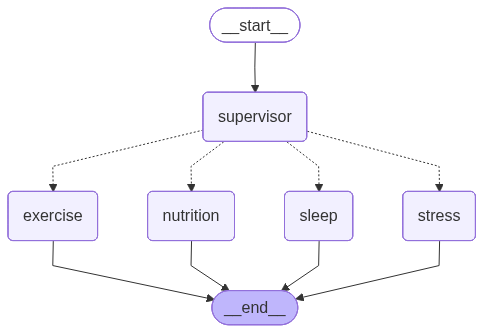

In [18]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

In [19]:
# Test the supervisor system
print("Testing Supervisor Multi-Agent System")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What exercises can help with lower back pain?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Supervisor Multi-Agent System
[Supervisor GPT-5.2] Routing to: exercise
  Reason: The user is asking for exercises to help with lower back pain, which is primarily a fitness/physical activity and movement topic best handled by the exercise specialist.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.

Final Response:
[EXERCISE SPECIALIST]

Here are some effective exercises that can help alleviate lower back pain:

1. **Cat-Cow Stretch**: 
   - Start on your hands and knees.
   - Alternate between arching your back up (Cat) and letting it sag down (Cow).
   - Perform 10-15 repetitions.

2. **Bird Dog**: 
   - From a hands-and-knees position, extend your opposite arm and leg while keeping your core engaged.
   - Hold for 5 seconds, then switch sides.
   - Do 10 repetitions per side.

3. **Partial Crunches**: 
   - Lie on your back with your knees bent and arms crossed over your chest.
   - Tighten your stomach muscles and raise your shoulders off the floo

In [20]:
# Test with a nutrition question
print("Testing with nutrition question")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What should I eat for better gut health?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with nutrition question
[Supervisor GPT-5.2] Routing to: nutrition
  Reason: The user is asking about what to eat to improve gut health, which is primarily a diet and food-choice question best handled by the nutrition specialist.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.

Final Response:
[NUTRITION SPECIALIST]

To improve your gut health, consider incorporating the following foods into your diet:

1. **Fermented Foods**: These are rich in probiotics, which support gut flora. Examples include:
   - Yogurt
   - Kefir
   - Sauerkraut
   - Kimchi
   - Miso
   - Kombucha

2. **Prebiotic Foods**: These help feed the good bacteria in your gut. Include:
   - Garlic
   - Onions
   - Bananas
   - Asparagus

3. **Fiber-Rich Foods**: Aim for 25-35 grams of fiber daily from sources like:
   - Whole grains (oats, brown rice)
   - Legumes (beans, lentils)
   - Vegetables (broccoli, carrots)

4. **Bone Broth**: This can help support gut lining health.

5. **H

## Task 4: Adding Tavily Search for Web Research

Sometimes the wellness knowledge base doesn't have the latest information. Let's add **Tavily Search** to allow agents to search the web for current information.

**Documentation:**
- [Tavily Search Tool](https://python.langchain.com/docs/integrations/tools/tavily_search/)
- [Tavily API Docs](https://docs.tavily.com/)

In [21]:
# Create a Tavily search tool (using updated langchain-tavily package)
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    topic="general"
)

print(f"Tavily search tool created: {tavily_search.name}")

Tavily search tool created: tavily_search


In [22]:
# Test Tavily search
search_results = tavily_search.invoke("latest research on benefits of morning exercise 2024")
print("Tavily Search Results:")
print("-" * 50)

for result in search_results['results'][:2]:
    print(f"\nTitle: {result.get('title', 'N/A')}")
    print(f"URL: {result.get('url', 'N/A')}")
    print(f"Content: {result.get('content', 'N/A')[:200]}...")

Tavily Search Results:
--------------------------------------------------

Title: Differential benefits of 12-week morning vs. evening ...
URL: https://www.nature.com/articles/s41598-025-02659-8
Content: by B Shen · 2025 · Cited by 11 — Morning exercise (6–8 am) is particularly effective for rapid body fat reduction, lowering plasma cholesterol and triglycerides, and advancing sleep-wake cycle....

Title: Comparative effectiveness of morning and evening aerobic ...
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC12036172/
Content: by J Sun · 2025 · Cited by 1 — Studies indicate that morning exercise is more effective for weight loss in college students who are overweight and obese, with a significant...


In [23]:
# Create a research agent that can search both the knowledge base AND the web
@tool
def search_wellness_kb(query: str) -> str:
    """Search the local wellness knowledge base for established health information.
    Use this first for general wellness questions.
    """
    results = retriever.invoke(query)
    if not results:
        return "No information found in knowledge base."
    return "\n\n".join([f"[KB Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_web_current(query: str) -> str:
    """Search the web for current/recent health and wellness information.
    Use this when you need the latest research, news, or information not in the knowledge base.
    """
    response = tavily_search.invoke(query)
    if not response or not response.get('results'):
        return "No web results found."
    formatted = []
    for i, r in enumerate(response['results'][:3]):
        formatted.append(f"[Web Source {i+1}]: {r.get('content', 'N/A')}\nURL: {r.get('url', 'N/A')}")
    return "\n\n".join(formatted)

# Create a research agent with both tools (using create_agent)
research_agent = create_agent(
    model=specialist_llm,
    tools=[search_wellness_kb, search_web_current],
    system_prompt="""You are a Wellness Research Agent. You have access to both a curated knowledge base 
and web search. Use the knowledge base for established information and web search for 
current/recent updates. Always cite your sources."""
)

print("Research agent with web search created (using create_agent)!")

Research agent with web search created (using create_agent)!


In [24]:
# Test the research agent
print("Testing Research Agent (KB + Web)")
print("=" * 50)

response = research_agent.invoke({
    "messages": [HumanMessage(content="What are the benefits of cold water immersion for recovery?")]
})

print("\nResearch Agent Response:")
print(response["messages"][-1].content)

Testing Research Agent (KB + Web)

Research Agent Response:
Cold water immersion (CWI), commonly known as ice baths or cold plunging, has gained popularity as a recovery technique among athletes and fitness enthusiasts. Here are some of the key benefits associated with cold water immersion for recovery:

1. **Reduction of Muscle Soreness**: CWI has been shown to help reduce delayed onset muscle soreness (DOMS), which is the muscle pain and stiffness that often occurs after intense exercise. This can lead to quicker recovery times and allow individuals to return to their training regimens sooner.

2. **Decreased Inflammation**: Cold water immersion can help reduce inflammation and cellular damage following strenuous exercise. The cold temperature constricts blood vessels, which can help limit swelling and tissue breakdown.

3. **Improved Recovery Time**: By reducing muscle soreness and inflammation, CWI can enhance overall recovery time, allowing athletes to perform at their best in sub

---
## ❓ Question #1:

In the Supervisor pattern, the supervisor routes requests to specialist agents. What are the **advantages** and **disadvantages** of having agents loop back to the supervisor after responding, versus having them respond directly to the user?

##### Answer:
In a loop-back architecture, agents return their responses to the supervisor, which can coordinate complex queries, combine outputs from multiple specialists into a coherent answer, reroute requests if an agent fails, and validate or correct responses before they reach the user. This enables centralized quality control and consistent formatting, but comes at the cost of higher latency, increased API usage, greater implementation complexity, and the risk of bottlenecks or a single point of failure at the supervisor, as well as reduced transparency about which agent produced which information.

When agents respond directly to the user, the system is simpler, faster, and more cost-efficient, and it scales better under high load while offering greater transparency. However, this approach limits coordination across specialists, makes it harder to enforce consistent quality and safety controls, and increases the risk of inconsistent or conflicting responses for complex queries.

## ❓ Question #2:

We added Tavily web search alongside the knowledge base. In what scenarios would you want to **restrict** an agent to only use the knowledge base (no web search)? What are the trade-offs between freshness and reliability?

##### Answer:
Restricting an agent to only use the knowledge base is appropriate in regulated industries (such as healthcare, finance, and legal), when data privacy is critical, in offline environments, and when consistent, reproducible responses are required for testing and quality assurance. In these cases, relying on approved and curated sources reduces risk and improves reliability.

The trade-off between freshness and reliability is that web search provides more up-to-date information but with variable quality, higher latency, and potential misinformation, while a curated knowledge base offers verified, predictable, and faster responses at the cost of becoming outdated and requiring manual maintenance. In practice, a hybrid approach is often best: default to the knowledge base and use web search only when fresh information is explicitly needed.

---
## 🏗️ Activity #1: Add a Custom Specialist Agent

Add a new specialist agent to the supervisor system. Ideas:
- **Habits Agent**: Helps with habit formation and routines
- **Hydration Agent**: Focuses on water intake and hydration
- **Lifestyle Agent**: Addresses work-life balance and digital wellness

Requirements:
1. Create a specialized search tool for your agent's domain
2. Create the specialist agent with an appropriate system prompt
3. Add the agent to the supervisor graph
4. Update the routing logic
5. Test with relevant questions

Supervisor state defined!
Supervisor node created (using GPT-5.2)!
Agent nodes created!
Supervisor multi-agent system built!
Flow: User -> Supervisor -> Specialist -> END


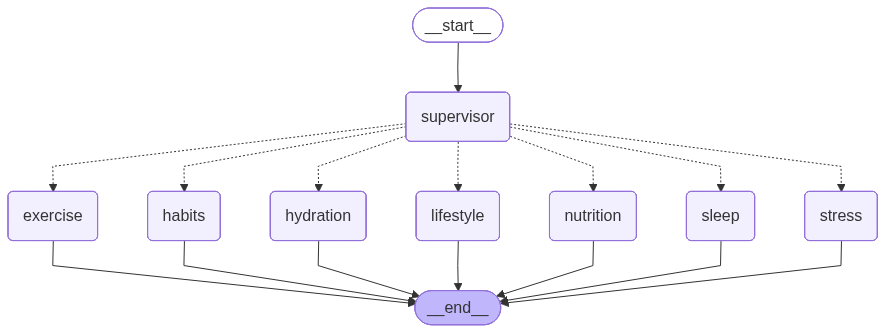

Testing Habits Agent
[Supervisor GPT-5.2] Routing to: habits
  Reason: Building a morning routine is primarily about habit formation, structuring consistent behaviors, and creating a repeatable sequence—best handled by the habits specialist.
[HABITS Agent] Processing request...
[HABITS Agent] Response complete.

Final Response:
[HABITS SPECIALIST]

To build a morning routine, consider the following steps:

1. **Start Small**: Begin with just a couple of minutes for each activity to avoid feeling overwhelmed.
   
2. **Wake Up at a Consistent Time**: This helps regulate your body's internal clock.

3. **Hydrate**: Drink a glass of water immediately after waking up.

4. **Incorporate Movement**: Spend 5-10 minutes doing light stretching or exercise.

5. **Eat a Healthy Breakfast**: Fuel your body with nutritious food.

6. **Mindfulness Practice**: Engage in a brief mindfulness exercise or journaling to set a positive tone for the day.

7. **Review Your Goals**: Take a moment to go over yo

In [25]:
### YOUR CODE HERE ###
# Step 1: Create a specialized search tool
#DEFINE HABITS, HYDRATION, LIFESTYLE TOOLS
@tool
def search_habits_info(query: str) -> str:
    """Search for habit formation, routines, and consistency information from the wellness knowledge base.
    Use this for questions about building habits, maintaining routines, and creating sustainable behavior changes.
    """
    results = retriever.invoke(f"habits consistency routine {query}")
    if not results:
        return "No habits information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_hydration_info(query: str) -> str:
    """Search for hydration and water intake information from the wellness knowledge base.
    Use this for questions about water intake, hydration, and health benefits.
    """
    results = retriever.invoke(f"hydration water intake {query}")
    if not results:
        return "No hydration information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_lifestyle_info(query: str) -> str:
    """Search for lifestyle and work-life balance information from the wellness knowledge base.
    Use this for questions about improving productivity, reducing stress, and achieving a balanced lifestyle.
    """
    results = retriever.invoke(f"lifestyle balance productivity {query}")
    if not results:
        return "No lifestyle information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

# Step 2: Create the specialist agent
#DEFINE HABITS, HYDRATION, LIFESTYLE AGENTS
habits_agent = create_agent(
    model=specialist_llm,
    tools=[search_habits_info],
    system_prompt="You are a Habits Specialist. Help users with habits to improve their life. Always search the knowledge base before answering. Be concise and helpful."
)

hydration_agent = create_agent(
    model=specialist_llm,
    tools=[search_hydration_info],
    system_prompt="You are a Hydration Specialist. Help users with water intake and hydration. Always search the knowledge base before answering. Be concise and helpful."
)

lifestyle_agent = create_agent(
    model=specialist_llm,
    tools=[search_lifestyle_info],
    system_prompt="You are a Lifestyle Specialist. Help users with improving productivity, reducing stress, and achieving a balanced lifestyle. Always search the knowledge base before answering. Be concise and helpful."
)

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutput(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["exercise", "nutrition", "sleep", "stress", "habits", "hydration", "lifestyle"]
    reasoning: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Supervisor state defined!")

# Create the supervisor node (using GPT-5.2 for routing decisions)
supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Wellness Supervisor coordinating a team of specialist agents.

Your team:
- exercise: Handles fitness, workouts, physical activity, movement questions
- nutrition: Handles diet, meal planning, healthy eating, food questions
- sleep: Handles sleep quality, insomnia, rest, recovery questions
- stress: Handles stress management, mindfulness, mental wellness, anxiety questions
- habits: Handles habit formation, routines, consistency, and behavior change questions
- hydration: Handles water intake, hydration, and health benefits
- lifestyle: Handles improving productivity, reducing stress, and achieving a balanced lifestyle
Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

# Create structured output for routing (using GPT-5.2)
routing_llm = supervisor_llm.with_structured_output(RouterOutput)

def supervisor_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Supervisor node created (using GPT-5.2)!")

# Create agent nodes that wrap the specialist agents

def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the specialist agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        agent_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each specialist
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
sleep_node = create_agent_node(sleep_agent, "sleep")
stress_node = create_agent_node(stress_agent, "stress")
habits_node = create_agent_node(habits_agent, "habits") 
hydration_node = create_agent_node(hydration_agent, "hydration")
lifestyle_node = create_agent_node(lifestyle_agent, "lifestyle")
print("Agent nodes created!")

# Step 3: Add to the supervisor graph (you may need to rebuild the graph)
# Build the supervisor graph
# KEY: Specialists go directly to END (no loop back to supervisor)

def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("exercise", exercise_node)
supervisor_workflow.add_node("nutrition", nutrition_node)
supervisor_workflow.add_node("sleep", sleep_node)
supervisor_workflow.add_node("stress", stress_node)
supervisor_workflow.add_node("habits", habits_node)
supervisor_workflow.add_node("hydration", hydration_node)
supervisor_workflow.add_node("lifestyle", lifestyle_node)   
# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "sleep": "sleep",
        "stress": "stress",
        "habits": "habits",
        "hydration": "hydration",
        "lifestyle": "lifestyle",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("exercise", END)
supervisor_workflow.add_edge("nutrition", END)
supervisor_workflow.add_edge("sleep", END)
supervisor_workflow.add_edge("stress", END)
supervisor_workflow.add_edge("habits", END)
supervisor_workflow.add_edge("hydration", END)
supervisor_workflow.add_edge("lifestyle", END)
# Compile
supervisor_graph = supervisor_workflow.compile()

print("Supervisor multi-agent system built!")
print("Flow: User -> Supervisor -> Specialist -> END")

# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

# Step 4: Test your new agent
print("Testing Habits Agent")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="How can I build a morning routine?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

print("=" * 50)
print("Testing Lifestyle Agent")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="How can I achieve better work-life balance?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

print("=" * 50)
print("Testing Hydration Agent")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="How much water should I drink per day?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

---
#  🤝 Breakout Room #2
## Handoffs & Context Engineering

## Task 5: Agent Handoffs Pattern

The **Handoffs Pattern** allows agents to transfer control to each other based on the conversation context. Unlike the supervisor pattern, agents decide themselves when to hand off.

```
    User Question
         │
         ▼
    ┌─────────┐    "I need nutrition help"   ┌─────────┐
    │ Fitness │ ─────────────────────────────► Nutrition│
    │  Agent  │                               │  Agent  │
    └─────────┘ ◄───────────────────────────── └─────────┘
                 "Back to fitness questions"
```

**Documentation:**
- [LangGraph Agent Handoffs](https://langchain-ai.github.io/langgraph/how-tos/agent-handoffs/)

In [26]:
# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_exercise(reason: str) -> str:
    """Transfer to Exercise Specialist for fitness, workouts, and physical activity questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:exercise:{reason}"

@tool
def transfer_to_nutrition(reason: str) -> str:
    """Transfer to Nutrition Specialist for diet, meal planning, and food questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:nutrition:{reason}"

@tool
def transfer_to_sleep(reason: str) -> str:
    """Transfer to Sleep Specialist for sleep quality, insomnia, and rest questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:sleep:{reason}"

@tool
def transfer_to_stress(reason: str) -> str:
    """Transfer to Stress Management Specialist for stress, anxiety, and mindfulness questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:stress:{reason}"

print("Handoff tools created!")

Handoff tools created!


In [27]:
# Create agents with handoff capabilities (using create_agent)

exercise_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_exercise_info,
        transfer_to_nutrition,
        transfer_to_sleep,
        transfer_to_stress
    ],
    system_prompt="""You are an Exercise Specialist. Answer fitness and workout questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering exercise questions."""
)

nutrition_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_nutrition_info,
        transfer_to_exercise,
        transfer_to_sleep,
        transfer_to_stress
    ],
    system_prompt="""You are a Nutrition Specialist. Answer diet and meal planning questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering nutrition questions."""
)

sleep_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_sleep_info,
        transfer_to_exercise,
        transfer_to_nutrition,
        transfer_to_stress
    ],
    system_prompt="""You are a Sleep Specialist. Answer sleep and rest questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering sleep questions."""
)

stress_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_stress_info,
        transfer_to_exercise,
        transfer_to_nutrition,
        transfer_to_sleep
    ],
    system_prompt="""You are a Stress Management Specialist. Answer stress and mindfulness questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering stress questions."""
)

print("Handoff-enabled agents created (using create_agent)!")

Handoff-enabled agents created (using create_agent)!


In [28]:
# Build the handoff graph with transfer limit to prevent infinite loops

class HandoffState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    current_agent: str
    transfer_count: int  # Track transfers to prevent infinite loops

MAX_TRANSFERS = 2  # Maximum number of handoffs allowed

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""

def create_handoff_node(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: HandoffState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        last_message = result["messages"][-1]
        
        # Check for handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        print(f"[{name.upper()}] Handing off to {target}: {reason}")
                        return {
                            "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                            "current_agent": target,
                            "transfer_count": state["transfer_count"] + 1
                        }
        
        # No handoff (or limit reached), return final response
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response], "current_agent": "done", "transfer_count": state["transfer_count"]}
    
    return node

# Create nodes
exercise_handoff_node = create_handoff_node(exercise_handoff_agent, "exercise")
nutrition_handoff_node = create_handoff_node(nutrition_handoff_agent, "nutrition")
sleep_handoff_node = create_handoff_node(sleep_handoff_agent, "sleep")
stress_handoff_node = create_handoff_node(stress_handoff_agent, "stress")

print("Handoff nodes created!")

Handoff nodes created!


In [31]:
# Build the handoff graph with initial routing (using GPT-5.2)

def entry_router(state: HandoffState):
    """Initial routing based on the user's question (using GPT-5.2)."""
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: exercise, nutrition, sleep, stress

Question: {user_question}

Respond with just the specialist name (one word)."""
    
    response = supervisor_llm.invoke(router_prompt)
    agent = response.content.strip().lower()
    
    # Validate
    if agent not in ["exercise", "nutrition", "sleep", "stress"]:
        agent = "stress"  # Default to stress for general wellness
    
    print(f"[Router GPT-5.2] Initial routing to: {agent}")
    return {"current_agent": agent, "transfer_count": 0}

def route_by_current_agent(state: HandoffState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Build graph
handoff_workflow = StateGraph(HandoffState)

# Add nodes
handoff_workflow.add_node("router", entry_router)
handoff_workflow.add_node("exercise", exercise_handoff_node)
handoff_workflow.add_node("nutrition", nutrition_handoff_node)
handoff_workflow.add_node("sleep", sleep_handoff_node)
handoff_workflow.add_node("stress", stress_handoff_node)

# Entry point
handoff_workflow.add_edge(START, "router")

# Router to agents
handoff_workflow.add_conditional_edges(
    "router",
    route_by_current_agent,
    {"exercise": "exercise", "nutrition": "nutrition", "sleep": "sleep", "stress": "stress"}
)

# Agents can handoff to each other or end
for agent_name in ["exercise", "nutrition", "sleep", "stress"]:
    handoff_workflow.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "exercise": "exercise",
            "nutrition": "nutrition", 
            "sleep": "sleep",
            "stress": "stress",
            "done": END
        }
    )

# Compile
handoff_graph = handoff_workflow.compile()

print("Handoff multi-agent system built!")

Handoff multi-agent system built!


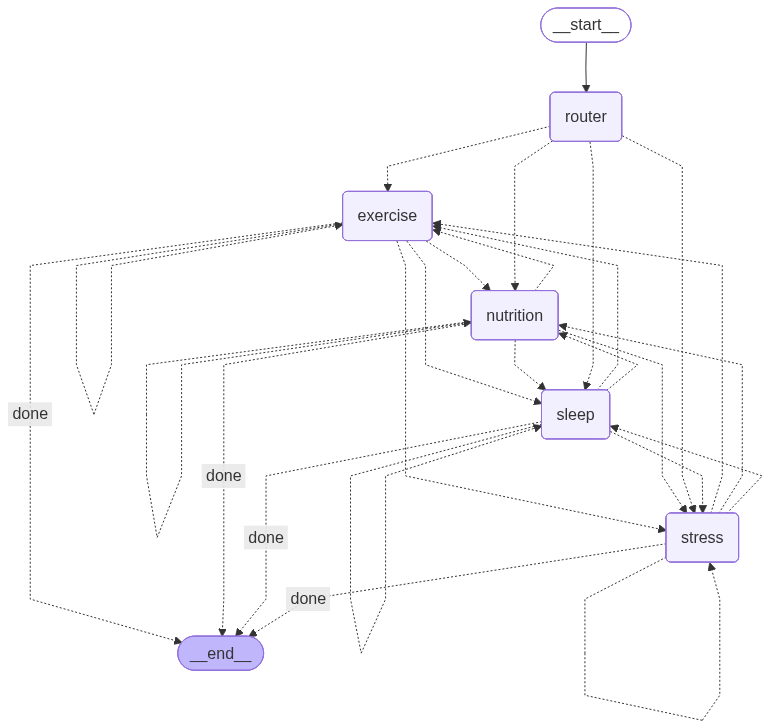

In [30]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(handoff_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(handoff_graph.get_graph().draw_ascii())

In [32]:
# Test the handoff system
print("Testing Handoff System")
print("=" * 50)

response = handoff_graph.invoke({
    "messages": [HumanMessage(content="I'm stressed and can't sleep. What should I do?")],
    "current_agent": "",
    "transfer_count": 0
})

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Handoff System
[Router GPT-5.2] Initial routing to: sleep
[SLEEP Agent] Processing...
[SLEEP] Handing off to stress: User is experiencing stress that is affecting their sleep.
[STRESS Agent] Processing...
[STRESS] Handing off to sleep: User is experiencing stress that is affecting their sleep.
[SLEEP Agent] Processing...
[SLEEP Agent] Response complete.

FINAL RESPONSE:
[SLEEP SPECIALIST]

I've transferred your concern to a Stress Management Specialist who can help you with your stress and its impact on your sleep. They will provide you with the appropriate guidance and support.


## Task 6: Building a Wellness Agent Team

Now let's combine what we've learned to build a complete wellness team that can:
1. Handle complex multi-domain questions
2. Search both the knowledge base and the web
3. Maintain conversation context
4. Provide comprehensive wellness advice

In [33]:
# Create a unified wellness team with memory
from langgraph.checkpoint.memory import MemorySaver

# Add memory to the supervisor graph
memory = MemorySaver()

supervisor_with_memory = supervisor_workflow.compile(checkpointer=memory)

print("Supervisor with memory created!")

Supervisor with memory created!


In [34]:
# Test multi-turn conversation
thread_id = "wellness-session-1"
config = {"configurable": {"thread_id": thread_id}}

print("Multi-turn Conversation Test")
print("=" * 50)

# First question
response1 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What's a good morning routine for energy?")]},
    config=config
)
print("\n[Turn 1 Response]:")
print(response1["messages"][-1].content[:500])

Multi-turn Conversation Test
[Supervisor GPT-5.2] Routing to: habits
  Reason: The user is asking for a structured morning routine to boost energy, which primarily involves building consistent routines and behavior patterns (habit formation). While sleep, nutrition, and exercise can contribute, the main request is about designing a routine.
[HABITS Agent] Processing request...
[HABITS Agent] Response complete.

[Turn 1 Response]:
[HABITS SPECIALIST]

A good morning routine to boost your energy can include the following steps:

1. **Wake Up at a Consistent Time**: Set a regular wake-up time to regulate your body's internal clock.
2. **Hydrate**: Start your day with a glass of water to rehydrate after sleep.
3. **Light Movement**: Engage in 5-10 minutes of stretching or light exercise to get your blood flowing.
4. **Healthy Breakfast**: Eat a nutritious breakfast that includes protein and healthy fats to fuel your body.
5.


In [35]:
# Follow-up question (should remember context)
response2 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What should I eat as part of that routine?")]},
    config=config
)
print("\n[Turn 2 Response]:")
print(response2["messages"][-1].content[:500])

[Supervisor GPT-5.2] Routing to: nutrition
  Reason: The user is asking what to eat as part of a routine, which is primarily a diet/meal planning question best handled by the nutrition specialist.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.

[Turn 2 Response]:
[NUTRITION SPECIALIST]

For a healthy breakfast that boosts energy, consider the following options:

1. **Overnight Oats**: Combine rolled oats with milk or yogurt, and top with berries and nuts for added fiber and healthy fats.
2. **Smoothie**: Blend spinach, banana, protein powder, and almond milk for a nutrient-packed drink.
3. **Eggs**: Scramble or poach eggs and serve with whole-grain toast and avocado for a protein-rich meal.
4. **Greek Yogurt Parfait**: Layer Greek yogurt with granola and


## Task 7: Context Engineering & Optimization

As conversations grow, we need to manage context carefully. Key principles:

1. **Context Window as Prime Real Estate**: Only include what's necessary
2. **Summarization**: Compress long conversations
3. **Selective Retrieval**: Don't retrieve everything, just what's relevant
4. **Context Rot**: More tokens doesn't mean better performance

In [36]:
# Implement a context summarization function (using GPT-4o-mini for cost efficiency)

def summarize_conversation(messages: list[BaseMessage], max_messages: int = 6) -> list[BaseMessage]:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the first message (original question) and last few messages
    old_messages = messages[1:-max_messages+1]
    recent_messages = messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation history in 2-3 sentences, 
capturing the key topics discussed and any important decisions made:

{chr(10).join([f'{m.type}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = specialist_llm.invoke(summary_prompt)
    
    # Return: first message + summary + recent messages
    return [
        messages[0],
        SystemMessage(content=f"[Previous conversation summary: {summary.content}]"),
        *recent_messages
    ]

print("Context summarization function created!")

Context summarization function created!


In [37]:
# Demonstrate context optimization
sample_messages = [
    HumanMessage(content="I want to get healthier"),
    AIMessage(content="Great! Let's start with your goals."),
    HumanMessage(content="I want to lose weight and sleep better"),
    AIMessage(content="Here are some exercise tips..."),
    HumanMessage(content="What about diet?"),
    AIMessage(content="For nutrition, consider..."),
    HumanMessage(content="And sleep?"),
    AIMessage(content="For better sleep..."),
    HumanMessage(content="How do I manage stress?"),
]

print(f"Original messages: {len(sample_messages)}")

optimized = summarize_conversation(sample_messages, max_messages=4)
print(f"Optimized messages: {len(optimized)}")
print("\nOptimized conversation:")
for msg in optimized:
    print(f"  [{msg.type}]: {msg.content[:100]}...")

Original messages: 9
Optimized messages: 5

Optimized conversation:
  [human]: I want to get healthier...
  [system]: [Previous conversation summary: The conversation focused on the human's goals of losing weight and i...
  [human]: And sleep?...
  [ai]: For better sleep......
  [human]: How do I manage stress?...


---
## ❓ Question #3:

Compare the **Supervisor pattern** and the **Handoffs pattern** we implemented. What are the key differences in how routing decisions are made? When would you choose one pattern over the other?

##### Answer:
In the Supervisor pattern, a central supervisor analyzes the user's question and makes a single routing decision at the start, directing the query to one specialist who responds directly to the user. The supervisor uses structured output (RouterOutput) to ensure consistent routing decisions with reasoning. Once a specialist is selected, that specialist handles the entire response without the ability to redirect to another agent. However, the supervisor can become a bottleneck under high load since all requests must pass through this central node.
In the Handoffs pattern, each specialist agent has the autonomy to transfer control to another specialist if they determine the question is better suited for a different domain. This creates a peer-to-peer communication model with a transfer limit (MAX_TRANSFERS = 2) to prevent infinite loops. However, this pattern introduces higher latency due to multiple agent invocations and carries a risk of getting stuck in loops if exit conditions are not properly defined.
The Supervisor pattern is better for predictable, fast responses with minimal latency when queries clearly fall into a single domain. The Handoffs pattern is better for complex queries spanning multiple domains (e.g., "I'm stressed and can't sleep"), where specialists can collaborate dynamically.

## ❓ Question #4:

We discussed "Context Rot" - the idea that longer context doesn't always mean better performance. How does this principle apply to multi-agent systems? What strategies can you use to manage context effectively across multiple agents?

##### Answer:
Context rot refers to the degradation of LLM performance as the context window fills with information, where important details get "lost in the middle" and the model struggles to identify what's relevant. In multi-agent systems, this problem is amplified because each agent adds its own messages, tool calls, and responses to the shared state, causing the context to grow rapidly across multiple agent invocations.

Strategies to manage context effectively across multiple agents include:
Context summarization - Periodically compress older messages into concise summaries while keeping recent interactions intact. This preserves important historical context without overwhelming the context window. For example, the summarize_conversation function in the code summarizes old messages into 2-3 sentences when the conversation exceeds a threshold.
Selective context passing - Instead of passing the entire conversation history to every agent, pass only the relevant portions. A supervisor can extract the key question and relevant context before routing to a specialist, rather than forwarding the full message history.
Agent-specific context windows - Each specialist agent only needs context relevant to its domain. An exercise specialist doesn't need detailed nutrition discussion history - just the current question and any exercise-related context.
Transfer limits and early termination - Using mechanisms like MAX_TRANSFERS = 2 prevents agents from endlessly passing context back and forth, which would continuously expand the context window.
Structured state management - Using typed state (like SupervisorState or HandoffState) with specific fields rather than free-form message accumulation helps control what information persists across agent transitions.

---
## 🏗️ Activity #2: Implement Hierarchical Teams

Build a **Hierarchical Agent System** where a top-level supervisor manages multiple team supervisors, each with their own specialist agents.

### Requirements:

1. Create a **Wellness Director** (top-level supervisor using GPT-5.2) that:
   - Receives user questions and determines which team should handle it
   - Routes to either the "Physical Wellness Team" or "Mental Wellness Team"
   - Aggregates final responses from teams

2. Create two **Team Supervisors**:
   - **Physical Wellness Team Lead**: Manages Exercise Agent and Nutrition Agent
   - **Mental Wellness Team Lead**: Manages Sleep Agent and Stress Agent

3. Implement the hierarchical routing:
   - User question → Wellness Director → Team Lead → Specialist Agent → Response

4. Test with questions that require different teams:
   - "What exercises help with weight loss?" (Physical team)
   - "How can I improve my sleep when stressed?" (Mental team)

### Architecture:
```
                    ┌─────────────────────┐
                    │  Wellness Director  │
                    │     (GPT-5.2)       │
                    └──────────┬──────────┘
                               │
              ┌────────────────┴────────────────┐
              │                                 │
              ▼                                 ▼
   ┌─────────────────────┐          ┌─────────────────────┐
   │  Physical Wellness  │          │  Mental Wellness    │
   │    Team Lead        │          │    Team Lead        │
   └──────────┬──────────┘          └──────────┬──────────┘
              │                                 │
       ┌──────┴──────┐                   ┌──────┴──────┐
       │             │                   │             │
       ▼             ▼                   ▼             ▼
  ┌─────────┐  ┌──────────┐        ┌─────────┐  ┌─────────┐
  │Exercise │  │Nutrition │        │  Sleep  │  │ Stress  │
  │  Agent  │  │  Agent   │        │  Agent  │  │  Agent  │
  └─────────┘  └──────────┘        └─────────┘  └─────────┘
```

**Documentation:**
- [LangGraph Hierarchical Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/)

In [ ]:
### YOUR CODE HERE ###

# Step 1: Create Team Supervisors (using GPT-5.2 for routing)
# These manage routing within their teams
# define 
class TeamRouterOutput(BaseModel):
    """Team supervisor routing decision."""
    next: str  # The specialist to route to within the team
    reasoning: str

# Physical Wellness Team Lead
physical_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Physical Wellness Team Lead.
Your team has two specialists:
- exercise: Handles fitness, workouts, and physical activity
- nutrition: Handles diet, meal planning, and healthy eating

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Mental Wellness Team Lead  
mental_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Mental Wellness Team Lead.
Your team has two specialists:
- sleep: Handles sleep quality, insomnia, and rest
- stress: Handles stress management, mindfulness, and mental wellness

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Step 2: Create the Wellness Director (top-level, using GPT-5.2)
class DirectorRouterOutput(BaseModel):
    """Director routing decision to teams."""
    team: Literal["physical", "mental"]
    reasoning: str

director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Wellness Director overseeing two teams:
- physical: Physical Wellness Team (exercise, nutrition)
- mental: Mental Wellness Team (sleep, stress)

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])



# Step 3: Build the hierarchical graph
# Hint: You'll need nested graphs or a state that tracks the current level



# Step 4: Test the hierarchical system
# test_question = "What exercises help with weight loss?"
# response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
# print(response["messages"][-1].content)

In [19]:
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

# Set API Keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

# Tavily API Key for web search
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - AI Engineering Bootcamp, Cohort 9 - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - AI Engineering Bootcamp, Cohort 9 - f605124d


Testing models...
Director (GPT-5.2): Director ready!
Team lead (GPT-5.2): Team lead ready!
Specialist (GPT-4o-mini): Specialist ready!
LangGraph and LangChain components imported!
Loaded and split into 45 chunks
Vector store ready with 45 documents
Specialist tools created
Specialist agents created
Team lead tools created
Team lead agents created
Director state defined!
Director node created (using GPT-5.2)!
Physical team lead node created (using GPT-5.2)!
Mental team lead node created (using GPT-5.2)!
Specialist nodes created!
Director multi-agent system built!
Flow: User -> Director -> Team Lead -> Specialist -> END


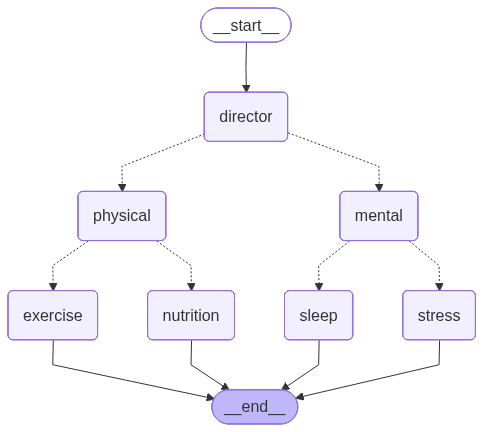

Testing Director Multi-Agent System
[Director GPT-5.2] Routing to: physical
  Reason: The user is asking about exercises that help with weight loss, which falls under exercise and nutrition guidance handled by the Physical Wellness Team.
[Physical team lead GPT-5.2] Routing to: exercise
  Reason: The user is asking which exercises help with weight loss, which falls under fitness/workouts and physical activity guidance rather than diet or meal planning.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.

Final Response:
[EXERCISE AGENT]

To aid in weight loss, consider incorporating the following types of exercises into your routine:

1. **Aerobic (Cardio) Exercises**: Aim for at least 150 minutes of moderate-intensity aerobic activity per week. Examples include:
   - Walking
   - Running
   - Cycling
   - Swimming

2. **Strength Training**: Engage in muscle-strengthening activities on 2 or more days per week. This can include:
   - Bodyweight exercises (squats, 

In [25]:
#import os
#import getpass
#import json
#from uuid import uuid4
#from typing import Annotated, TypedDict, Literal, Sequence
#import operator

#import nest_asyncio
#nest_asyncio.apply()  # Required for async operations in Jupyter

# Set API Keys
#os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

# Tavily API Key for web search
#os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

# Optional: LangSmith for tracing
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Applications - {uuid4().hex[0:8]}"
#os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

#if not os.environ["LANGCHAIN_API_KEY"]:
#    os.environ["LANGCHAIN_TRACING_V2"] = "false"
#    print("LangSmith tracing disabled")
#else:
#    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

# Initialize LLMs - GPT-5.2 for director and team leads, GPT-4o-mini for specialists
from langchain_openai import ChatOpenAI

# Direcor model - better reasoning for routing and orchestration
director_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Team lead model - cost-effective for domain-specific tasks
team_lead_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test both models
print("Testing models...")
director_response = director_llm.invoke("Say 'Director ready!' in exactly 2 words.")
team_lead_response = team_lead_llm.invoke("Say 'Team lead ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Director (GPT-5.2): {director_response.content}")
print(f"Team lead (GPT-5.2): {team_lead_response.content}") 
print(f"Specialist (GPT-4o-mini): {specialist_response.content}")

# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

# First, let's set up our RAG system for the wellness knowledge base
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

# Set up vector store
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="wellness_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="wellness_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} documents")

# Create specialized tools for each agent domain

@tool
def search_exercise_info(query: str) -> str:
    """Search for exercise, fitness, and workout information from the wellness knowledge base.
    Use this for questions about physical activity, workout routines, and exercise techniques.
    """
    results = retriever.invoke(f"exercise fitness workout {query}")
    if not results:
        return "No exercise information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_nutrition_info(query: str) -> str:
    """Search for nutrition, diet, and healthy eating information from the wellness knowledge base.
    Use this for questions about food, meal planning, and dietary guidelines.
    """
    results = retriever.invoke(f"nutrition diet food meal {query}")
    if not results:
        return "No nutrition information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_sleep_info(query: str) -> str:
    """Search for sleep, rest, and recovery information from the wellness knowledge base.
    Use this for questions about sleep quality, insomnia, and sleep hygiene.
    """
    results = retriever.invoke(f"sleep rest recovery insomnia {query}")
    if not results:
        return "No sleep information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_stress_info(query: str) -> str:
    """Search for stress management and mental wellness information from the wellness knowledge base.
    Use this for questions about stress, anxiety, mindfulness, and mental health.
    """
    results = retriever.invoke(f"stress mental wellness mindfulness anxiety {query}")
    if not results:
        return "No stress management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

print("Specialist tools created")

# Create specialist agents using create_agent (LangChain 1.0 API)
# Each specialist uses GPT-4o-mini for cost efficiency

exercise_agent = create_agent(
    model=specialist_llm,
    tools=[search_exercise_info],
    system_prompt="You are an Exercise Specialist. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

nutrition_agent = create_agent(
    model=specialist_llm,
    tools=[search_nutrition_info],
    system_prompt="You are a Nutrition Specialist. Help users with diet advice, meal planning, and healthy eating. Always search the knowledge base before answering. Be concise and helpful."
)

sleep_agent = create_agent(
    model=specialist_llm,
    tools=[search_sleep_info],
    system_prompt="You are a Sleep Specialist. Help users with sleep quality, insomnia, and rest optimization. Always search the knowledge base before answering. Be concise and helpful."
)

stress_agent = create_agent(
    model=specialist_llm,
    tools=[search_stress_info],
    system_prompt="You are a Stress Management Specialist. Help users with stress relief, mindfulness, and mental wellness. Always search the knowledge base before answering. Be concise and helpful."
)

print("Specialist agents created")


@tool
def call_exercise_specialist(query: str) -> str:
    """Call the Exercise Specialist for fitness and workout questions.
    
    Args:
        query: The user's question about exercise
    """
    result = exercise_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

@tool
def call_nutrition_specialist(query: str) -> str:
    """Call the Nutrition Specialist for diet and nutrition questions.
    
    Args:
        query: The user's question about diet and nutrition
    """
    result = nutrition_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

@tool
def call_sleep_specialist(query: str) -> str:
    """Call the Sleep Specialist for sleep quality and insomnia questions.

    Args:
        query: The user's question about sleep and insomnia
    """
    result = sleep_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

@tool
def call_stress_specialist(query: str) -> str:
    """Call the Stress Management Specialist for stress relief and mental wellness questions.

    Args:
        query: The user's question about stress and mental wellness
    """
    result = stress_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content   

print("Team lead tools created")

physical_agent = create_agent(
    model=team_lead_llm,
    tools=[call_exercise_specialist, call_nutrition_specialist],
    system_prompt="You are a Physical Wellness Team Lead. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

mental_agent = create_agent(
    model=team_lead_llm,
    tools=[call_sleep_specialist, call_stress_specialist],
    system_prompt="You are a Mental Wellness Team Lead. Help users with sleep quality, insomnia, and stress management. Always search the knowledge base before answering. Be concise and helpful."
)
print("Team lead agents created")

# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class DirectorRouterOutput(BaseModel):
    """Director routing decision to teams."""
    team: Literal["physical", "mental"]
    reasoning: str

class DirectorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Director state defined!")

# Create the director node (using GPT-5.2 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate


director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Wellness Director overseeing two teams:
- physical: Physical Wellness Team (exercise, nutrition)
- mental: Mental Wellness Team (sleep, stress)

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])

# Create structured output for routing (using GPT-5.2)
director_routing_llm = director_llm.with_structured_output(DirectorRouterOutput)

def director_node(state: DirectorState):
    """The director decides which team to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = director_prompt.invoke({"question": user_question})
    result = director_routing_llm.invoke(prompt_value)
    
    print(f"[Director GPT-5.2] Routing to: {result.team}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.team}

print("Director node created (using GPT-5.2)!")

physical_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Physical Wellness Team Lead.
Your team has two specialists:
- exercise: Handles fitness, workouts, and physical activity
- nutrition: Handles diet, meal planning, and healthy eating

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

class PhysicalRouterOutput(BaseModel):
    """Physical routing decision to teams."""
    next: Literal["exercise", "nutrition"]
    reasoning: str

physical_routing_llm = team_lead_llm.with_structured_output(PhysicalRouterOutput)

def physical_lead_node(state: DirectorState):
    """The physical team lead decides which team to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = physical_team_prompt.invoke({"question": user_question})
    result = physical_routing_llm.invoke(prompt_value)
    
    print(f"[Physical team lead GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Physical team lead node created (using GPT-5.2)!")


class MentalRouterOutput(BaseModel):
    """Mental routing decision to teams."""
    next: Literal["sleep", "stress"]
    reasoning: str

mental_routing_llm = team_lead_llm.with_structured_output(MentalRouterOutput)

# Mental Wellness Team Lead  
mental_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Mental Wellness Team Lead.
Your team has two specialists:
- sleep: Handles sleep quality, insomnia, and rest
- stress: Handles stress management, mindfulness, and mental wellness

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

def mental_lead_node(state: DirectorState):
    """The mental team lead decides which team to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = mental_team_prompt.invoke({"question": user_question})
    result = mental_routing_llm.invoke(prompt_value)
    
    print(f"[Mental team lead GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Mental team lead node created (using GPT-5.2)!")


# Create team Agent nodes that wrap the agents
def create_agent_node(agent, name: str):
    """Create a node that runs an agent and returns the final response."""
    def agent_node(state: DirectorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        team_lead_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} AGENT]\n\n{team_lead_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each team lead
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
sleep_node = create_agent_node(sleep_agent, "sleep")
stress_node = create_agent_node(stress_agent, "stress")

print("Specialist nodes created!")

# Build the director graph
def route_to_team_lead(state: DirectorState) -> str:
    """Route to the next agent based on director decision."""
    return state["next"]

def route_to_specialist(state: DirectorState) -> str:
    """Route to the next agent based on team lead decision."""
    return state["next"]

# Create the graph
director_workflow = StateGraph(DirectorState)
# Add edges: START -> director
director_workflow.add_edge(START, "director")
director_workflow.add_node("director", director_node)
director_workflow.add_node("physical", physical_lead_node)
director_workflow.add_node("mental", mental_lead_node)
director_workflow.add_node("exercise", exercise_node)
director_workflow.add_node("nutrition", nutrition_node)
director_workflow.add_node("sleep", sleep_node)
director_workflow.add_node("stress", stress_node)

# Conditional routing from director to team leads
director_workflow.add_conditional_edges(
    "director",
    route_to_team_lead,
    {
        "physical": "physical",
        "mental": "mental",
    },
)
director_workflow.add_conditional_edges(
    "physical",
    route_to_specialist,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
    },
)
director_workflow.add_conditional_edges(
    "mental",
    route_to_specialist,
    {
        "sleep": "sleep",
        "stress": "stress",
    },
)
director_workflow.add_edge("exercise", END)
director_workflow.add_edge("nutrition", END)
director_workflow.add_edge("sleep", END)
director_workflow.add_edge("stress", END)

# Compile
director_graph = director_workflow.compile()

print("Director multi-agent system built!")
print("Flow: User -> Director -> Team Lead -> Specialist -> END")

# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(director_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(director_graph.get_graph().draw_ascii())

    # Test the director system
print("Testing Director Multi-Agent System")
print("=" * 50)

response = director_graph.invoke({
    "messages": [HumanMessage(content="What exercises help with weight loss?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

print("=" * 50)
print("Testing Director Multi-Agent System")
print("=" * 50)

response = director_graph.invoke({
    "messages": [HumanMessage(content="How can I improve my sleep when stressed?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)


Testing models...
Director (GPT-5.2): Director ready!
Team lead (GPT-5.2): Team lead ready!
Specialist (GPT-4o-mini): Specialist ready!
LangGraph and LangChain components imported!
Loaded and split into 45 chunks
Vector store ready with 45 documents
Specialist tools created
Specialist agents created
Team lead tools created
Team lead agents created
Director state defined!
Director node created
Physical team lead node created
Mental team lead node created
Specialist nodes created
Director multi-agent system built!
Flow: User -> Director -> Team Lead -> Specialist -> Team Lead -> Director -> User


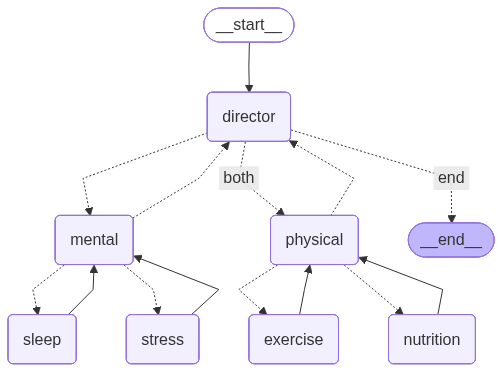

Testing Director Multi-Agent System
[Director] Routing to: physical
  Reason: The user is asking specifically about exercises for weight loss, which falls under exercise and fitness guidance handled by the Physical Wellness Team.
[Physical team lead] Routing to: exercise
  Reason: The user asks specifically about exercises that help with weight loss, which falls under workout selection, training modalities, and physical activity guidance—best handled by the Exercise Specialist.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.

Final Response:
[WELLNESS DIRECTOR]

To support weight loss, focus on a balanced routine you can sustain—combining cardio, strength training, and supportive movement.

## 1) Aerobic (Cardio) Exercise
Aim for **at least 150 minutes per week of moderate-intensity cardio** (more can help accelerate progress if tolerated). Examples include:
- Brisk walking  
- Running/jogging  
- Cycling  
- Swimming  

## 2) Strength (Resistance) Training
I

In [27]:
#import os
#import getpass
#import json
#from uuid import uuid4
#from typing import Annotated, TypedDict, Literal, Sequence
#import operator

#import nest_asyncio
#nest_asyncio.apply()  # Required for async operations in Jupyter

# Set API Keys
#os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

# Tavily API Key for web search
#os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

# Optional: LangSmith for tracing
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Applications - {uuid4().hex[0:8]}"
#os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

#if not os.environ["LANGCHAIN_API_KEY"]:
#    os.environ["LANGCHAIN_TRACING_V2"] = "false"
#    print("LangSmith tracing disabled")
#else:
#    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

# Initialize LLMs - GPT-5.2 for director and team leads, GPT-4o-mini for specialists
from time import sleep
from langchain_openai import ChatOpenAI

# Direcor model - better reasoning for routing and orchestration
director_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Team lead model - cost-effective for domain-specific tasks
team_lead_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test both models
print("Testing models...")
director_response = director_llm.invoke("Say 'Director ready!' in exactly 2 words.")
team_lead_response = team_lead_llm.invoke("Say 'Team lead ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Director (GPT-5.2): {director_response.content}")
print(f"Team lead (GPT-5.2): {team_lead_response.content}") 
print(f"Specialist (GPT-4o-mini): {specialist_response.content}")

# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

# First, let's set up our RAG system for the wellness knowledge base
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

# Set up vector store
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="wellness_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="wellness_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} documents")

# Create specialized tools for each agent domain
@tool
def search_exercise_info(query: str) -> str:
    """Search for exercise, fitness, and workout information from the wellness knowledge base.
    Use this for questions about physical activity, workout routines, and exercise techniques.
    """
    results = retriever.invoke(f"exercise fitness workout {query}")
    if not results:
        return "No exercise information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_nutrition_info(query: str) -> str:
    """Search for nutrition, diet, and healthy eating information from the wellness knowledge base.
    Use this for questions about food, meal planning, and dietary guidelines.
    """
    results = retriever.invoke(f"nutrition diet food meal {query}")
    if not results:
        return "No nutrition information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_sleep_info(query: str) -> str:
    """Search for sleep, rest, and recovery information from the wellness knowledge base.
    Use this for questions about sleep quality, insomnia, and sleep hygiene.
    """
    results = retriever.invoke(f"sleep rest recovery insomnia {query}")
    if not results:
        return "No sleep information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_stress_info(query: str) -> str:
    """Search for stress management and mental wellness information from the wellness knowledge base.
    Use this for questions about stress, anxiety, mindfulness, and mental health.
    """
    results = retriever.invoke(f"stress mental wellness mindfulness anxiety {query}")
    if not results:
        return "No stress management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

print("Specialist tools created")

# Create specialist agents using create_agent (LangChain 1.0 API)
exercise_agent = create_agent(
    model=specialist_llm,
    tools=[search_exercise_info],
    system_prompt="You are an Exercise Specialist. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

nutrition_agent = create_agent(
    model=specialist_llm,
    tools=[search_nutrition_info],
    system_prompt="You are a Nutrition Specialist. Help users with diet advice, meal planning, and healthy eating. Always search the knowledge base before answering. Be concise and helpful."
)

sleep_agent = create_agent(
    model=specialist_llm,
    tools=[search_sleep_info],
    system_prompt="You are a Sleep Specialist. Help users with sleep quality, insomnia, and rest optimization. Always search the knowledge base before answering. Be concise and helpful."
)

stress_agent = create_agent(
    model=specialist_llm,
    tools=[search_stress_info],
    system_prompt="You are a Stress Management Specialist. Help users with stress relief, mindfulness, and mental wellness. Always search the knowledge base before answering. Be concise and helpful."
)

print("Specialist agents created")


@tool
def call_exercise_specialist(query: str) -> str:
    """Call the Exercise Specialist for fitness and workout questions.
    
    Args:
        query: The user's question about exercise
    """
    result = exercise_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

@tool
def call_nutrition_specialist(query: str) -> str:
    """Call the Nutrition Specialist for diet and nutrition questions.
    
    Args:
        query: The user's question about diet and nutrition
    """
    result = nutrition_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

@tool
def call_sleep_specialist(query: str) -> str:
    """Call the Sleep Specialist for sleep quality and insomnia questions.

    Args:
        query: The user's question about sleep and insomnia
    """
    result = sleep_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

@tool
def call_stress_specialist(query: str) -> str:
    """Call the Stress Management Specialist for stress relief and mental wellness questions.

    Args:
        query: The user's question about stress and mental wellness
    """
    result = stress_agent.invoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content   
print("Team lead tools created")

physical_agent = create_agent(
    model=team_lead_llm,
    tools=[call_exercise_specialist, call_nutrition_specialist],
    system_prompt="You are a Physical Wellness Team Lead. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

mental_agent = create_agent(
    model=team_lead_llm,
    tools=[call_sleep_specialist, call_stress_specialist],
    system_prompt="You are a Mental Wellness Team Lead. Help users with sleep quality, insomnia, and stress management. Always search the knowledge base before answering. Be concise and helpful."
)
print("Team lead agents created")

# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks one or both specialists
class DirectorRouterOutput(BaseModel):
    """Director routing decision to teams."""
    team: Literal["physical", "mental", "both"]
    reasoning: str

class DirectorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str
    director_routing_decision: str | None
    physical_routing_decision: str | None
    mental_routing_decision: str | None
print("Director state defined!")

# Create the director node (using GPT-5.2 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate


director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Wellness Director overseeing two teams:
- physical: Physical Wellness Team (exercise, nutrition)
- mental: Mental Wellness Team (sleep, stress)

Based on the user's question, decide:
- "physical" if only the Physical Wellness Team should handle it
- "mental" if only the Mental Wellness Team should handle it
- "both" if the question requires input from both teams (e.g., "How can I lose weight while managing stress?")

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])

# Create structured output for routing (using GPT-5.2)
director_routing_llm = director_llm.with_structured_output(DirectorRouterOutput)

def director_node(state: DirectorState):
    """The director decides which team to route to or aggregate the response from the team leads and specialists."""
   
    # Find the last response from the physical and mental teams
    routing_decision = state.get("director_routing_decision", None)
    physical_response = None
    mental_response = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage) and hasattr(msg, 'name') and msg.name:
            if msg.name == "physical_team":
                physical_response = msg.content
            elif msg.name == "mental_team":
                mental_response = msg.content
    
    if not physical_response and not mental_response:
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        # Get routing decision
        prompt_value = director_prompt.invoke({"question": user_question})
        result = director_routing_llm.invoke(prompt_value)
        
        print(f"[Director] Routing to: {result.team}")
        print(f"  Reason: {result.reasoning}")
       
        
        # If the decision is "both", first call physical
        if result.team == "both":
            return {"next": "physical", "director_routing_decision": "both"}
        else:
            return {"next": result.team, "director_routing_decision": result.team}
    
    elif physical_response and not mental_response:
        if routing_decision == "both":
            return {"next": "mental"}
        else:
            user_question = ""
            for msg in reversed(state["messages"]):
                if isinstance(msg, HumanMessage):
                    user_question = msg.content
                    break
            aggregation_prompt = f"""Refine and format this team response:
                {physical_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = director_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[WELLNESS DIRECTOR]\n\n{aggregated_response.content}", name="WELLNESS DIRECTOR")],
            "next": "end"
        }
        
    elif physical_response and mental_response:
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        aggregation_prompt = f"""Combine these team responses into one comprehensive answer:
            Physical Team: {physical_response}
            Mental Team: {mental_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = director_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[WELLNESS DIRECTOR]\n\n{aggregated_response.content}", name="WELLNESS DIRECTOR")],
            "next": "end"
        }
    else: 
        single_response = physical_response or mental_response
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        aggregation_prompt = f"""Refine and format this team response:
            {single_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = director_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[WELLNESS DIRECTOR]\n\n{aggregated_response.content}", name="WELLNESS DIRECTOR")],
            "next": "end"
        }
    
print("Director node created")

physical_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Physical Wellness Team Lead.
Your team has two specialists:
- exercise: Handles fitness, workouts, and physical activity
- nutrition: Handles diet, meal planning, and healthy eating

Based on the user's question, decide:
- "exercise" if only the Exercise Specialist should handle it
- "nutrition" if only the Nutrition Specialist should handle it
- "both" if the question requires input from both specialists

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

class PhysicalRouterOutput(BaseModel):
    """Physical routing decision to teams."""
    next: Literal["exercise", "nutrition", "both"]
    reasoning: str

physical_routing_llm = team_lead_llm.with_structured_output(PhysicalRouterOutput)

def physical_lead_node(state: DirectorState):
    """The physical team lead decides which specialist to route to or aggregate the response from the specialists."""
   
    # Find the last response from the exercise and nutrition specialists
    routing_decision = state.get("physical_routing_decision", None)
    exercise_response = None
    nutrition_response = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage) and hasattr(msg, 'name') and msg.name:
            if msg.name == "exercise":
                exercise_response = msg.content
            elif msg.name == "nutrition":
                nutrition_response = msg.content
    
    if not exercise_response and not nutrition_response:
        # Get the user's question from the last human message
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        
        # Get routing decision
        prompt_value = physical_team_prompt.invoke({"question": user_question})
        result = physical_routing_llm.invoke(prompt_value)
        
        print(f"[Physical team lead] Routing to: {result.next}")
        print(f"  Reason: {result.reasoning}")
            
        # If the decision is "both", first call exercise
        if result.next == "both":
            return {"next": "exercise", "physical_routing_decision": "both"}
        else:
            return {"next": result.next, "physical_routing_decision": result.next}
    
    elif exercise_response and not nutrition_response:
        if routing_decision == "both":
            return {"next": "nutrition"}
        else:
            user_question = ""
            for msg in reversed(state["messages"]):
                if isinstance(msg, HumanMessage):
                    user_question = msg.content
                    break
            aggregation_prompt = f"""Refine and format this specialist response:
                {exercise_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
            aggregated_response = team_lead_llm.invoke(aggregation_prompt)
            return {
                "messages": [AIMessage(content=f"[PHYSICAL TEAM LEAD]\n\n{aggregated_response.content}", name="physical_team")],
                "next": "director"
            }
    
    elif exercise_response and nutrition_response:
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        aggregation_prompt = f"""Combine these specialist responses into one comprehensive answer:
            Exercise Specialist: {exercise_response}
            Nutrition Specialist: {nutrition_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = team_lead_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[PHYSICAL TEAM LEAD]\n\n{aggregated_response.content}", name="physical_team")],
            "next": "director"
        }
    else: 
        single_response = exercise_response or nutrition_response
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        aggregation_prompt = f"""Refine and format this specialist response:
            {single_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = team_lead_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[PHYSICAL TEAM LEAD]\n\n{aggregated_response.content}", name="physical_team")],
            "next": "director"
        }

print("Physical team lead node created")


class MentalRouterOutput(BaseModel):
    """Mental routing decision to teams."""
    next: Literal["sleep", "stress", "both"]
    reasoning: str

mental_routing_llm = team_lead_llm.with_structured_output(MentalRouterOutput)

# Mental Wellness Team Lead  
mental_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Mental Wellness Team Lead.
Your team has two specialists:
- sleep: Handles sleep quality, insomnia, and rest
- stress: Handles stress management, mindfulness, and mental wellness

Based on the user's question, decide:
- "sleep" if only the Sleep Specialist should handle it
- "stress" if only the Stress Specialist should handle it
- "both" if the question requires input from both specialists

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])
    
def mental_lead_node(state: DirectorState):
    """The mental team lead decides which specialist to route to or aggregate the response from the specialists."""
   
    # Find the last response from the sleep and stress specialists
    routing_decision = state.get("mental_routing_decision", None)
    sleep_response = None
    stress_response = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage) and hasattr(msg, 'name') and msg.name:
            if msg.name == "sleep":
                 sleep_response = msg.content
            elif msg.name == "stress":
                stress_response = msg.content
    
    if not sleep_response and not stress_response:
        # Get the user's question from the last human message
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        
        # Get routing decision
        prompt_value = mental_team_prompt.invoke({"question": user_question})
        result = mental_routing_llm.invoke(prompt_value)
        
        print(f"[Mental team lead] Routing to: {result.next}")
        print(f"  Reason: {result.reasoning}")
            
        # If the decision is "both", first call sleep
        if result.next == "both":
            return {"next": "sleep", "mental_routing_decision": "both"}
        else:
            return {"next": result.next, "mental_routing_decision": result.next}
    
    elif sleep_response and not stress_response:
        if routing_decision == "both":
            return {"next": "stress"}
        else:
            user_question = ""
            for msg in reversed(state["messages"]):
                if isinstance(msg, HumanMessage):
                    user_question = msg.content
                    break
            aggregation_prompt = f"""Refine and format this specialist response:
                {sleep_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
            aggregated_response = team_lead_llm.invoke(aggregation_prompt)
            return {
                "messages": [AIMessage(content=f"[MENTAL TEAM LEAD]\n\n{aggregated_response.content}", name="mental_team")],
                "next": "director"
            }
    
    elif sleep_response and stress_response:
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        aggregation_prompt = f"""Combine these specialist responses into one comprehensive answer:
            Sleep Specialist: {sleep_response}
            Stress Specialist: {stress_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = team_lead_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[MENTAL TEAM LEAD]\n\n{aggregated_response.content}", name="mental_team")],
            "next": "director"
        }
    else: 
        single_response = sleep_response or stress_response
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break
        aggregation_prompt = f"""Refine and format this specialist response:
            {single_response}
            Original question: {user_question}
            Provide a polished, well-structured final response."""
        aggregated_response = team_lead_llm.invoke(aggregation_prompt)
        return {
            "messages": [AIMessage(content=f"[MENTAL TEAM LEAD]\n\n{aggregated_response.content}", name="mental_team")],
            "next": "director"
        }

print("Mental team lead node created")

# Create team Agent nodes that wrap the agents
def create_agent_node(agent, name: str):
    """Create a node that runs an agent and returns the final response."""
    def agent_node(state: DirectorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        team_lead_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} AGENT]\n\n{team_lead_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each team lead
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
sleep_node = create_agent_node(sleep_agent, "sleep")
stress_node = create_agent_node(stress_agent, "stress")

print("Specialist nodes created")

# Build the director graph
def route_to_team_lead(state: DirectorState) -> str:
    """Route to the next agent based on director decision."""
    return state["next"]

def route_to_specialist(state: DirectorState) -> str:
    """Route to the next agent based on team lead decision."""
    return state["next"]

# Create the graph
director_workflow = StateGraph(DirectorState)
# Add edges: START -> director
director_workflow.add_edge(START, "director")
director_workflow.add_node("director", director_node)
director_workflow.add_node("physical", physical_lead_node)
director_workflow.add_node("mental", mental_lead_node)
director_workflow.add_node("exercise", exercise_node)
director_workflow.add_node("nutrition", nutrition_node)
director_workflow.add_node("sleep", sleep_node)
director_workflow.add_node("stress", stress_node)

# Conditional routing from director to team leads
director_workflow.add_conditional_edges(
    "director",
    route_to_team_lead,
    {
        "physical": "physical",
        "mental": "mental",
        "both": "physical", 
        "end": END
    },
)
director_workflow.add_conditional_edges(
    "physical",
    route_to_specialist,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "director": "director"
        
    },
)
director_workflow.add_conditional_edges(
    "mental",
    route_to_specialist,
    {
        "sleep": "sleep",
        "stress": "stress",
        "director": "director"
    },
)
director_workflow.add_edge("exercise", "physical")
director_workflow.add_edge("nutrition", "physical")
director_workflow.add_edge("sleep", "mental")
director_workflow.add_edge("stress", "mental")

# Compile
director_graph = director_workflow.compile()

print("Director multi-agent system built!")
print("Flow: User -> Director -> Team Lead -> Specialist -> Team Lead -> Director -> User")

# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(director_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(director_graph.get_graph().draw_ascii())

    # Test the director system
print("Testing Director Multi-Agent System")
print("=" * 50)

response = director_graph.invoke({
    "messages": [HumanMessage(content="What exercises help with weight loss?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

print("=" * 50)
print("Testing Director Multi-Agent System")
print("=" * 50)

response = director_graph.invoke({
    "messages": [HumanMessage(content="How can I improve my sleep when stressed?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

print("=" * 50)
print("Testing Director Multi-Agent System")
print("=" * 50)

response = director_graph.invoke({
    "messages": [HumanMessage(content="I want to lose weight through exercise and healthy eating, but I'm also stressed and having trouble sleeping. Can you help me create a complete wellness plan?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

---
## Summary

In this session, we:

1. **Understood Multi-Agent Systems**: When to use them and key patterns
2. **Built a Supervisor Pattern**: Central orchestrator routing to specialists
3. **Implemented Agent Handoffs**: Agents transferring control to each other
4. **Added Web Search**: Tavily for current information alongside knowledge base
5. **Applied Context Engineering**: Managing context for optimal performance

### Key Takeaways:

- **Don't over-engineer**: Only add agents when you truly need specialization
- **Context is key**: Manage your context window carefully
- **Patterns matter**: Choose the right pattern for your use case

**Further Reading:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)